In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing

In [3]:
next_station_dict = { 
    'Xavier Hall': 'Fine Arts Annex',
    'Fine Arts Annex': 'Loyola House of Studies',
    'Loyola House of Studies': 'Grade School',
    'Grade School': 'Gate 2.5',
    'Gate 2.5': 'Leong Hall',
    'Leong Hall': 'Xavier Hall'
}

In [4]:
df = pd.read_csv('Complete_Out.csv')
df = df.drop(columns=['Unnamed: 0', 'Datetime'])

df.dtypes

Day                                         float64
Encoded Day                                 float64
Time                                        float64
Hour_of_Day                                 float64
IsEJeep1                                    float64
IsEJeep2                                    float64
Altitude                                    float64
Humidity                                    float64
Temperature                                 float64
Latitude                                    float64
Longitude                                   float64
Lat Diff                                    float64
Long Diff                                   float64
Distance                                    float64
Cum Distance                                float64
Abs Distance                                float64
Percent Distance                            float64
Encoded Station                             float64
IsStation                                   float64
IsCharging  

In [5]:
frame=1
[[df['Longitude'][frame], df['Latitude'][frame]]]

[[0.99994468578642, 0.9992878072355867]]

In [6]:
myDf = pd.DataFrame(columns=['Longitude', 'Latitude'])
# make random data to fill myDF columns until 20 rows
for i in range(20):
    myDf = myDf.append({'Longitude': np.random.randint(0, 10), 'Latitude': np.random.randint(0, 10)}, ignore_index=True)
    
myDf


/var/folders/5l/rqbcwgpj3rn89b6_cfpmypf80000gn/T/ipykernel_23542/2691547559.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myDf = myDf.append({'Longitude': np.random.randint(0, 10), 'Latitude': np.random.randint(0, 10)}, ignore_index=True)
/var/folders/5l/rqbcwgpj3rn89b6_cfpmypf80000gn/T/ipykernel_23542/2691547559.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myDf = myDf.append({'Longitude': np.random.randint(0, 10), 'Latitude': np.random.randint(0, 10)}, ignore_index=True)
/var/folders/5l/rqbcwgpj3rn89b6_cfpmypf80000gn/T/ipykernel_23542/2691547559.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myDf = myDf.append({'Longitude': np.random.randint(0, 10), 'Latitude': np.random.randint(0, 10)}, ignore_index=True

,Longitude,Latitude
0,1,2
1,1,5
2,3,9
3,3,8
4,4,2
5,0,1
6,4,1
7,4,2
8,4,0
9,5,9


In [7]:
print(df.columns)

Index(['Day', 'Encoded Day', 'Time', 'Hour_of_Day', 'IsEJeep1', 'IsEJeep2',
       'Altitude', 'Humidity', 'Temperature', 'Latitude', 'Longitude',
       'Lat Diff', 'Long Diff', 'Distance', 'Cum Distance', 'Abs Distance',
       'Percent Distance', 'Encoded Station', 'IsStation', 'IsCharging',
       'Encoded Prev Station', 'Prev Station Lat', 'Prev Station Long',
       'Prev Abs Distance', 'Prev Cum Distance',
       'Previous Time to Xavier Hall', 'Previous Time to Fine Arts Annex',
       'Previous Time to Loyola House of Studies',
       'Previous Time to Grade School', 'Previous Time to Gate 2.5',
       'Previous Time to Leong Hall', 'Encoded Next Station',
       'Next Station Lat', 'Next Station Long', 'Next Time to Xavier Hall',
       'Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies',
       'Next Time to Grade School', 'Next Time to Gate 2.5',
       'Next Time to Leong Hall'],
      dtype='object')


In [8]:
type(df['Latitude'][10004:10005])

pandas.core.series.Series

In [9]:
type(df['Latitude'][10005])

numpy.float64

<IPython.core.display.Javascript object>


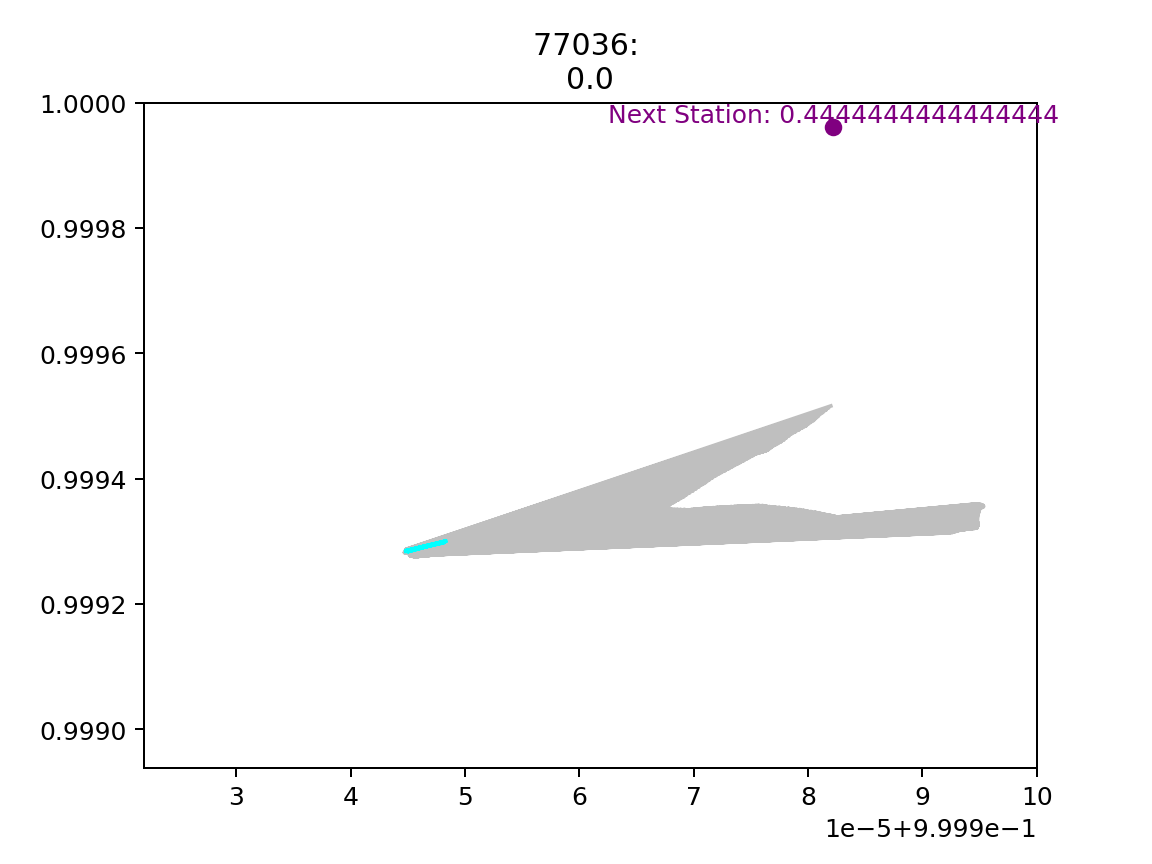

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

length = 60*15  # see past 15 minutes of track
speed = 60*2    # multiplier (1 min per second)

# Create a figure and axis
fig, ax = plt.subplots()

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Animation of Data')
xMin = df['Latitude'].min()
xMax = df['Latitude'].max()
yMin = df['Longitude'].min()
yMax = df['Longitude'].max()

# Define the update function for the animation
def update(frame):
    ax.clear()
    colors = [[]]
    ax.plot(df['Longitude'][frame:frame+length], df['Latitude'][frame:frame+length], color=(0.5,0.5,0.5, 0.5))
    ax.plot(df['Longitude'][frame+length-30:frame+length], df['Latitude'][frame+length-30:frame+length], color=(1-min(df['Distance'][frame+length]*100,1),min(df['Distance'][frame+length]*100,1),min(df['Distance'][frame+length]*100,1)))
    ax.set_xlim(0.9999219332, xMax)  # Set x-axis limits
    ax.set_ylim(0.9989382032, yMax)  # Set y-axis limits
    ax.set_title(f"{frame+length}: \n{df['Next Time to Xavier Hall'][frame+length]}")
    
    if(df['IsStation'][frame+length]):
        ax.scatter(df['Longitude'][frame+length], df['Latitude'][frame+length], color="green")  # Make the station point red and larger
    ax.scatter(df['Next Station Long'][frame+length], df['Next Station Lat'][frame+length], color="purple")
    ax.text(df['Next Station Long'][frame+length], df['Next Station Lat'][frame+length], f"Next Station: {df['Encoded Next Station'][frame+length]}", ha='center', va='bottom', color='purple')
    
    # Add text on the right side
    text_x = xMax + (xMax - xMin) * 0.05  # Adjust the x-coordinate of the text
    text_y = yMax - (yMax - yMin) * 0.05  # Adjust the y-coordinate of the text
    ax.text(text_x, text_y, f"Time: {df['Time'][frame+length]}\nHumidity: {df['Humidity'][frame+length]}", ha='left', va='top')
        
# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(5000,len(df)-length, speed//20), interval=1000//20)

# Display the animation
plt.show()


In [ ]:
# Convert all the times into a timestamp with 0 = 00:00:00 and 86399 = 23:59:59

def time_to_daytimestamp(stamp: str) -> int:
    if stamp is None:
        return -1
    
    if isinstance(stamp, float):
        return -1
    
    h, m, s = stamp.split(':')
    return int(h) * 24 * 60 + int(m) * 60 + int(s)

df['Time'] = df['Time'].apply(lambda time: time_to_daytimestamp(time))

df['Previous Time to Xavier Hall'] = df['Previous Time to Xavier Hall'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Fine Arts Annex'] = df['Previous Time to Fine Arts Annex'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Loyola House of Studies'] = df['Previous Time to Loyola House of Studies'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Grade School'] = df['Previous Time to Grade School'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Gate 2.5'] = df['Previous Time to Gate 2.5'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Leong Hall'] = df['Previous Time to Leong Hall'].apply(lambda time: time_to_daytimestamp(time))

df['Next Time to Xavier Hall'] = df['Next Time to Xavier Hall'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Fine Arts Annex'] = df['Next Time to Fine Arts Annex'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Loyola House of Studies'] = df['Next Time to Loyola House of Studies'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Grade School'] = df['Next Time to Grade School'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Gate 2.5'] = df['Next Time to Gate 2.5'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Leong Hall'] = df['Next Time to Leong Hall'].apply(lambda time: time_to_daytimestamp(time))

df

In [ ]:
df = df.fillna(-1)
df

df.to_csv('Updated Out.csv')

In [ ]:
X = df.copy()
X_train = X[:300_000]
X_test = X[300_001:]

# Xs is X but without the next time columns within it
Xs_train = X_train.copy()
Xs_test = X_test.copy()

Xs_train = Xs_train.drop(columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])
Xs_test = Xs_test.drop(columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])

Y_train = X_train.copy()
Y_test = X_test.copy()

Y_train = Y_train[['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall', 'IsEJeep1', 'IsEJeep2', 'IsEJeep3']]
Y_train = Y_train.dropna()

Y_test = Y_test[['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall', 'IsEJeep1', 'IsEJeep2', 'IsEJeep3']]
Y_test = Y_test.dropna()

assert(len(X_train) == len(Y_train))
assert(len(X_test) == len(Y_test))

In [ ]:
## Use Xs instead of X, remove next time in X

X_train = Xs_train
X_test = Xs_test

## Remove isEJeep_num in Y

Y_train = Y_train.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])
Y_test = Y_test.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])

assert(len(X_train) == len(Y_train))
assert(len(X_test) == len(Y_test))

# XGBoost Regression

In [ ]:
from xgboost import XGBRegressor

# xgb objective rmse
model_xgb = XGBRegressor(objective='reg:squarederror')
model_xgb.fit(X_train, Y_train)


In [ ]:
### Not working
%%script echo skipping

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

# hyperparamters gird search
model_xgb = XGBRegressor(objective='reg:squarederror')
params = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.1, 0.2]}
grid = GridSearchCV(estimator=model_xgb, param_grid=params, scoring='neg_mean_squared_error', cv=4, verbose=1)
grid.fit(X_train, Y_train)
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))



# model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05)
# model_xgb.fit(X_train, Y_train)

# xgb objective rmse
# model_xgb = XGBRegressor(objective='reg:squarederror')
# model_xgb.fit(X_train, Y_train)

# Predict the model 
# pred = model_xgb.predict(X_test)
# # put column labels on prediction
# pred = pd.DataFrame(data=pred, columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])


# rmse = np.sqrt(MSE(Y_test, pred))
# print(rmse)


In [ ]:

# xgb based on the best params
model_xgb = XGBRegressor(objective='reg:squarederror', max_depth=grid_result.best_params_['max_depth'], n_estimators=grid_result.best_params_['n_estimators'])

In [ ]:
# Predict the model 
pred = model_xgb.predict(X_test)
# put column labels on prediction
pred = pd.DataFrame(data=pred, columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])

In [ ]:
from sklearn.metrics import mean_squared_error as MSE 
  
# Metrics Computation 
rmse = np.sqrt(MSE(Y_test, pred))
r2 = r2_score(Y_test, pred)
mae = mean_absolute_error(Y_test, pred)

print("XGBoost Regression") 
print("RMSE : % f" %(rmse)) 
print("R^2 : % f" %(r2))
print("MAE : % f" %(mae))

In [ ]:
# plot Y_test vs pred
# make color change depending on how close the prediction to the actial value
plt.figure(figsize=(15, 15))
plt.plot(Y_test, pred, 'o', color='black')
plt.xlabel('Y_test')
plt.ylabel('pred')
plt.title('Y_test vs pred')
plt.show()

In [ ]:
# plot how close the prediction to the actual value
plt.figure(figsize=(15, 15))
plt.plot(Y_test, pred.subtract(Y_test.reset_index(drop=True)), 'o', color='black')
plt.xlabel('Y_test')
plt.ylabel('pred - Y_test')
plt.title('XGBoost: Single Prediction Error')
plt.show()

In [ ]:
# plot how close the prediction to the actual value
plt.figure(figsize=(15, 15))
# plt.plot(Y_test['Next Time to Leong Hall'], pred.subtract(Y_test.reset_index(drop=True))['Next Time to Leong Hall'], 'o', color='black')
# plt.xlabel('Y_test')
# plt.ylabel('pred - Y_test')
# plt.title('XGBoost: Single Prediction Error')
# plt.show()

# make a 3x2 graph
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
# go through all stations
for i, station in enumerate(next_station_dict.keys()):
    # plot how close the prediction to the actual value
    axs[i//2, i%2].plot(Y_test[f'Next Time to {station}'], pred.subtract(Y_test.reset_index(drop=True))[f'Next Time to {station}'], 'o', color='black')
    axs[i//2, i%2].set_xlabel('Y_test')
    axs[i//2, i%2].set_ylabel('pred - Y_test')
    axs[i//2, i%2].set_title(f'XGBoost: Single Prediction Error for {station}')

In [ ]:
model_xgb.save_model('xgb.model')

In [ ]:
f_importance_gain = model_xgb.get_booster().get_score(importance_type='gain')
#sort the dictionary
f_importance_gain = sorted(f_importance_gain.items(), key=lambda x:x[1], reverse=True)
f_importance_gain
#plot top 10 features
df_gain = pd.DataFrame(f_importance_gain[:10], columns=['feature', 'gain'])
plt.figure(figsize=(10, 5))
sns.barplot(x='gain', y='feature', data=df_gain)
plt.title('Feature Importance by Gain')
plt.show()


In [ ]:
f_importance_weight = model_xgb.get_booster().get_score(importance_type='weight')
#sort the dictionary
f_importance_weight = sorted(f_importance_weight.items(), key=lambda x:x[1], reverse=True)
f_importance_weight
df_weight = pd.DataFrame(f_importance_weight[:10], columns=['feature', 'weight'])
plt.figure(figsize=(10, 5))
sns.barplot(x='weight', y='feature', data=df_weight)
plt.title('Feature Importance by Weight')
plt.show()


In [ ]:
# XGB plot top 10 important features
from xgboost import plot_importance
plot_importance(model_xgb, max_num_features=10)
plt.show()


In [ ]:
f_importance

In [ ]:
# Check XGBoost Feature importance
# plot feature importance
plt.figure(figsize=(15, 15))
plt.bar(X_train.columns, model_xgb.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('XGBoost: Feature Importance')
plt.show()


In [ ]:
# fig, ax = plt.subplots(figsize=(30, 30))
import xgboost
xgboost.plot_tree(model_xgb, num_trees=1, ax=ax, rankdir='LR', )
# plt.show()


# Linear Regression Part

In [ ]:
assert(False)

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)

model_s_lr = LinearRegression()
model_s_lr.fit(Xs_train, Y_train)

In [ ]:
df_output = pd.DataFrame().reindex_like(Y_train)
df_s_output = pd.DataFrame().reindex_like(Y_train)

In [ ]:
def daytimestamp_to_time(val: int) -> str:
    h = val // (24 * 60)
    m_s = val % (24 * 60)
    m = m_s // 60
    s = m_s % 60

    return f'{h:02}:{m:02}:{s:02}'

In [ ]:
i = 0

for index, row in X_test.iterrows():
    y_hat = model_lr.predict(row.to_frame().transpose())
    df_output.loc[len(df_output)] = y_hat[0]

df_output

In [ ]:
for index, row in Xs_test.iterrows():
    y_hat = model_s_lr.predict(row.to_frame().transpose())
    df_s_output.loc[len(df_s_output)] = y_hat[0]

df_s_output

In [ ]:
df_output.to_csv('Linear Reg Output.csv')
df_s_output.to_csv('Linear Reg Spec Output.csv')

In [ ]:
Y_test = Y_test.dropna()
df_output = df_output.dropna()
df_s_output = df_s_output.dropna()

Y_test = Y_test.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])
df_output = df_output.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])
df_s_output = df_s_output.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])

In [ ]:
# Calculating MSE for all columns
rmse = mean_squared_error(Y_test, df_output, squared=False)
rmse_s = mean_squared_error(Y_test, df_s_output, squared=False)

mae = mean_absolute_error(Y_test, df_output)
mae_s = mean_absolute_error(Y_test, df_s_output)

r2 = r2_score(Y_test, df_output)
r2_s = r2_score(Y_test, df_s_output)

print('With Next Time of Arrival in Train Dataset:')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'MAE: {mae}')

In [ ]:
# print a row of X_test and Y_test
print(X.iloc[300100])
print(Y_test.iloc[100])